In [5]:
import tensorflow as tf
import numpy as np
import pandas as pd
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Conv1D, Dense, LSTM, Dropout, TimeDistributed, Bidirectional, Concatenate, GlobalAveragePooling1D, AdditiveAttention
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Activation
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer


In [6]:
url_data = 'https://raw.githubusercontent.com/TeodorRusKvi/Tekstanalyse/main/git_NLP_data/'

# Last inn 'X_train_LSTM' fra en CSV-fil
X_df = pd.read_csv(url_data+'X_tensorflow.csv')
# Konverter hele DataFrame til et NumPy array
X = X_df.to_numpy()

# Last inn 'y_train_LSTM' fra en CSV-fil
y_df = pd.read_csv(url_data+'y_liberal.csv')
# Konverter hele DataFrame til et NumPy array
y = y_df.to_numpy()

# Last inn 'y_train_LSTM' fra en CSV-fil
embeddings_GloVe = pd.read_csv(url_data+'embeddings_glove.csv')
# Konverter hele DataFrame til et NumPy array
embeddings_GloVe = embeddings_GloVe.to_numpy()


# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

## LSTM

In [12]:
tf.random.set_seed(42)

#batch_size = None
#batch_size=64

def model_build():
    model = Sequential()
    model.add(Input(shape=(20,)))
    # Adding the Embedding layer with pre-trained weights and specifying input_length
    model.add(Embedding(input_dim=embeddings_GloVe.shape[0],
                        output_dim=embeddings_GloVe.shape[1],
                        weights=[embeddings_GloVe],
                        trainable=False))
    model.add(Dropout(0.20))
    model.add(Bidirectional(LSTM(64, # Number of hidden states, number of reccurent units for each vector
        activation='tanh',
        recurrent_activation='sigmoid',
        recurrent_dropout=0.2,
        return_sequences=False)))

    model.add(Dense(77, activation='relu'))
    model.add(Dropout(0.20))
    model.add(Dense(num_classes, activation='sigmoid'))

    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

num_classes = 1
model = model_build()
# Model summary
model.summary()

early_stopping_callback = EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 20, 100)           2223500   
                                                                 
 dropout_3 (Dropout)         (None, 20, 100)           0         
                                                                 
 bidirectional_3 (Bidirecti  (None, 128)               84480     
 onal)                                                           
                                                                 
 dense_5 (Dense)             (None, 77)                9933      
                                                                 
 dropout_4 (Dropout)         (None, 77)                0         
                                                                 
 dense_6 (Dense)             (None, 1)                 78        
                                                      

In [13]:
input_length = 20
num_classes = 1
EPOCHS=20
BATCH_SIZE = 32

model = model_build()

early_stopping_callback = EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)


history = model.fit(X_train, y_train,
                    epochs=20,
                    validation_data=(X_val, y_val),
                    batch_size=BATCH_SIZE,
                    callbacks=early_stopping_callback)

# wandb.finish()

Epoch 1/20
282/282 [==============================] - 11s 18ms/step - loss: 0.6080 - accuracy: 0.6691 - val_loss: 0.5679 - val_accuracy: 0.7101
Epoch 2/20
282/282 [==============================] - 4s 15ms/step - loss: 0.5639 - accuracy: 0.7080 - val_loss: 0.5455 - val_accuracy: 0.7267
Epoch 3/20
282/282 [==============================] - 4s 15ms/step - loss: 0.5376 - accuracy: 0.7248 - val_loss: 0.5455 - val_accuracy: 0.7261
Epoch 4/20
282/282 [==============================] - 4s 15ms/step - loss: 0.5013 - accuracy: 0.7564 - val_loss: 0.5362 - val_accuracy: 0.7474
Epoch 5/20
282/282 [==============================] - 6s 21ms/step - loss: 0.4791 - accuracy: 0.7656 - val_loss: 0.5160 - val_accuracy: 0.7505
Epoch 6/20
282/282 [==============================] - 4s 15ms/step - loss: 0.4479 - accuracy: 0.7869 - val_loss: 0.5186 - val_accuracy: 0.7531
Epoch 7/20
282/282 [==============================] - 4s 16ms/step - loss: 0.4062 - accuracy: 0.8075 - val_loss: 0.5328 - val_accuracy: 0.755

In [ ]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test, batch_size=BATCH_SIZE)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

61/61 [==============================] - 1s 18ms/step - loss: 0.6295 - accuracy: 0.7475
Test Loss: 0.6295157670974731
Test Accuracy: 0.7475376129150391


In [11]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 20, 100)           2223500   
                                                                 
 bidirectional_2 (Bidirecti  (None, 128)               84480     
 onal)                                                           
                                                                 
 dense_3 (Dense)             (None, 77)                9933      
                                                                 
 dropout_2 (Dropout)         (None, 77)                0         
                                                                 
 dense_4 (Dense)             (None, 1)                 78        
                                                                 
Total params: 2317991 (8.84 MB)
Trainable params: 94491 (369.11 KB)
Non-trainable params: 2223500 (8.48 MB)
____________

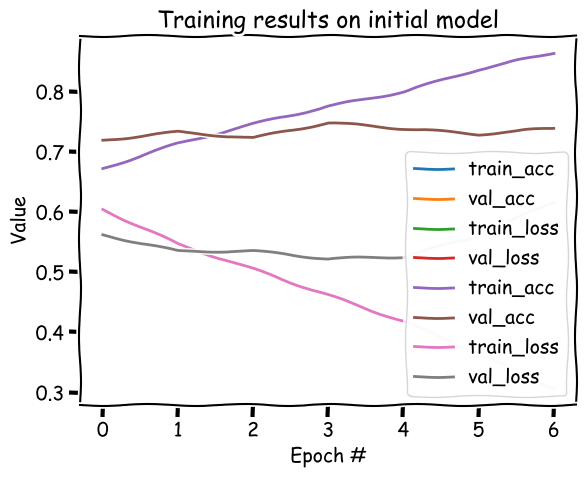

In [ ]:
import logging
logging.getLogger('matplotlib.font_manager').disabled = True

with plt.xkcd():
    plt.plot(history.history['accuracy'], label='train_acc')
    plt.plot(history.history['val_accuracy'], label='val_acc')
    plt.plot(history.history['loss'], label='train_loss')
    plt.plot(history.history['val_loss'], label='val_loss')



    plt.xlabel('Epoch #')
    plt.ylabel('Value')
    plt.title('Training results on initial model')
    plt.legend()

    plt.show()

In [ ]:
with plt.xkcd():
    plt.plot(POS_text_model.history['accuracy'], label='train_acc')
    plt.plot(POS_text_model.history['val_accuracy'], label='val_acc')
    plt.plot(POS_text_model.history['loss'], label='train_loss')
    plt.plot(POS_text_model.history['val_loss'], label='val_loss')

    plt.xlabel('Epoch #')
    plt.ylabel('Value')
    plt.title('Training results on initial model')
    plt.legend()

    plt.show()

NameError: name 'POS_text_model' is not defined